In [3]:
import sys
print(sys.executable)

/Users/zeynepcetin/PycharmProjects/BPIChallenge/.venv/bin/python


In [4]:
import pm4py
import pandas as pd

print("\n=== SECTION 3.1: TECHNICAL SETUP AND PRELIMINARIES ===")
file_path = "BPI Challenge 2017.xes.gz"
log = pm4py.read_xes(file_path)
log_df = pm4py.convert_to_dataframe(log)
log_obj = pm4py.convert_to_event_log(log)
print("---Data loaded---")



=== SECTION 3.1: TECHNICAL SETUP AND PRELIMINARIES ===


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:31<00:00, 988.71it/s]


---Data loaded---


In [5]:
import numpy as np
import pandas as pd

print("\n=== SECTION 3.2: PREPROCESSING ===")

CASE = "case:concept:name"
ACT  = "concept:name"
TS   = "time:timestamp"
RES = "org:resource"

required_cols = [CASE, ACT, TS,RES]
missing = [c for c in required_cols if c not in log_df.columns]

if missing:
    print("Missing required columns:", missing)
    raise ValueError("Core event log columns are missing. Preprocessing aborted.")

print("Original dataset shape:", log_df.shape)

log_df = log_df.replace(
    to_replace=["None", "none", "NONE", "", " "],
    value=np.nan
)
print("After normalizing None-like values:", log_df.shape)


log_df[TS] = pd.to_datetime(log_df[TS], utc=True, errors="coerce")

before_ts = log_df.shape[0]
log_df = log_df.dropna(subset=[TS])
after_ts = log_df.shape[0]

print(f"Timestamps: {before_ts - after_ts} invalid entries removed.")
print("After timestamp enforcement:", log_df.shape)

before_core = log_df.shape[0]
log_df = log_df.dropna(subset=required_cols)
after_core = log_df.shape[0]

print(f"Core-attribute filtering removed {before_core - after_core} rows.")
print("After enforcing core attributes:", log_df.shape)

log_df = (
    log_df
    .sort_values(by=[CASE, TS])
    .reset_index(drop=True)
)
print("Events sorted by case and timestamp.")

ts_diff = log_df.groupby(CASE)[TS].diff()

viol_mask = ts_diff < pd.Timedelta(0)

n_viol = int(viol_mask.sum())

violations_per_case = viol_mask.groupby(log_df[CASE]).sum()

if n_viol == 0:
    print("No temporal inconsistencies within cases.")
else:
    print(f"{n_viol} decreasing-timestamp violations detected across all cases.")
    print(" Likely caused by inconsistent event recording in the raw log.")

print("\nPreprocessing completed. log_df is cleaned and ready for discovery.")





=== SECTION 3.2: PREPROCESSING ===
Original dataset shape: (1202267, 19)
After normalizing None-like values: (1202267, 19)
Timestamps: 0 invalid entries removed.
After timestamp enforcement: (1202267, 19)
Core-attribute filtering removed 0 rows.
After enforcing core attributes: (1202267, 19)
Events sorted by case and timestamp.
No temporal inconsistencies within cases.

Preprocessing completed. log_df is cleaned and ready for discovery.


In [6]:
print("\n=== SECTION 3.3: BASIC ANALYSIS ===")
print("Columns:\n",log_df.columns.tolist())
RES = "org:resource"
#Events
num_events = len(log_df)

#Cases
num_cases = log_df[CASE].nunique()
events_per_case = log_df.groupby(CASE).size()
cases = log_df[CASE].unique()

#Process Variants
variants = pm4py.get_variants_as_tuples(log_obj)
num_variants = len(variants)

#Activity
num_activities = log_df[ACT].nunique()
activity_counts = log_df[ACT].value_counts()
top10_activities = activity_counts.head(10) #first 10

#Timestamp
#earliest latest
earliest_ts =  log_df[TS].min()
latest_ts = log_df[TS].max()

#case durations
case_times = log_df.groupby(CASE)[TS].agg(["min","max"])
durations_sec = (case_times["max"]-case_times["min"]).dt.total_seconds() #sec

#case length mean std
mean_case_length= float(events_per_case.mean())
std_case_length = float(events_per_case.std(ddof=1)) if len(events_per_case) > 1 else float("nan")

#ddof delta degrees of freedom sample std
mean_days,    std_days    = durations_sec.mean()/86400.0, durations_sec.std(ddof=1)/86400.0
mean_minutes, std_minutes = durations_sec.mean()/60.0,    durations_sec.std(ddof=1)/60.0
mean_seconds, std_seconds = durations_sec.mean(),         durations_sec.std(ddof=1)

#case & event labels
case_label_columns= [c for c in log_df.columns if c.startswith("case:")]
case_label_num = len(case_label_columns)
event_label_columns = [c for c in log_df.columns if not c.startswith("case:")]
event_label_num = len(event_label_columns)

#categorical event attributes
event_df = log_df[event_label_columns].copy()

categorical_event_attr = [
    c for c in event_df.columns
    if (event_df[c].dtype == "object") or (str(event_df[c].dtype).startswith("category"))
]
num_categorical_event_attr = len(categorical_event_attr)

#Resources
num_resources = log_df[RES].nunique()
most_active_resources= log_df[RES].value_counts().head(10)
top_resource = most_active_resources.index[0]
top_resource_count = int(most_active_resources.iloc[0])

#case specific
loan_goals = log_df["case:LoanGoal"].value_counts(normalize=True).mul(100).round(3)
top10_loan_goals_str = " ,".join([f"{goal}: {pct}%" for goal, pct in loan_goals.head(10).items()])
new_credit_or_limit_raise = log_df["case:ApplicationType"].value_counts(normalize=True).mul(100).round(2).to_dict()
app_distribution_str = ", ".join([f"{k}: {v}%" for k, v in new_credit_or_limit_raise.items()])

summary_rows = [
    ("Number of cases", num_cases),
    ("Number of events", num_events),
    ("Number of process variants", num_variants),
    ("Number of distinct activity labels", num_activities),
    ("Number of case attribute columns", case_label_num),
    ("Number of event attribute columns", event_label_num),
    ("Mean case length (events)", round(mean_case_length, 3)),
    ("Std. case length (events)", round(std_case_length, 3) if not pd.isna(std_case_length) else None),
    ("Mean case duration (days)", round(mean_days, 3)),
    ("Std. case duration (days)", round(std_days, 3)),
    ("Mean case duration (minutes)", round(mean_minutes, 3)),
    ("Std. case duration (minutes)", round(std_minutes, 3)),
    ("Mean case duration (seconds)", round(mean_seconds, 3)),
    ("Std. case duration (seconds)", round(std_seconds, 3)),
    ("Number of categorical event attributes", num_categorical_event_attr),
    ("Number of distinct resources (org:resource)", num_resources),
    ("Most active resource", f"{top_resource} ({top_resource_count} events)"),
    ("Most frequent activity", top10_activities.index[0]),
    ("Most frequent activity count", int(top10_activities.iloc[0])),
    ("Most common loan goal",f"{loan_goals.index[0]} ({loan_goals.iloc[0]}%)"),
    ("Application type distribution", f"New credit: {round(new_credit_or_limit_raise.get('New credit',0),2)}%, "
     f"Limit raise: {round(new_credit_or_limit_raise.get('Limit raise',0),2)}%")
]

#Basic analysis table
summary_df = pd.DataFrame(summary_rows, columns=["Metric", "Value"])

#Top 10 acts
top10_activities_df = top10_activities.head(10).reset_index()
top10_activities_df.columns = ["Activity", "Count"]
top10_activities_df

#Top 10 resources
top10_resources_df = most_active_resources.head(10).reset_index()
top10_resources_df.columns = ["Resource", "Count"]

#Loan goal distribution
loan_goals_df = loan_goals.head(10).reset_index()
loan_goals_df.columns = ["LoanGoal", "Percentage"]

#Appl type distribution
app_type_df = (
    pd.DataFrame
    .from_dict(new_credit_or_limit_raise, orient="index", columns=["Percentage"])
    .reset_index()
    .rename(columns={"index": "ApplicationType"})
)

print("=== BASIC ANALYSIS SUMMARY TABLE ===")
display(summary_df)

print("\n=== TOP 10 ACTIVITIES ===")
display(top10_activities_df)

print("\n=== TOP 10 RESOURCES ===")
display(top10_resources_df)

print("\n=== LOAN GOAL DISTRIBUTION (TOP 10) ===")
display(loan_goals_df)

print("\n=== APPLICATION TYPE DISTRIBUTION ===")
display(app_type_df)

summary_df.to_csv("tables/basic_analysis_summary.csv", index=False)
top10_activities_df.to_csv("tables/top10_activities.csv", index=False)
top10_resources_df.to_csv("tables/top10_resources.csv", index=False)
loan_goals_df.to_csv("tables/loan_goals_top10.csv", index=False)
app_type_df.to_csv("tables/application_type_distribution.csv", index=False)




=== SECTION 3.3: BASIC ANALYSIS ===
Columns:
 ['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID', 'lifecycle:transition', 'time:timestamp', 'case:LoanGoal', 'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore', 'OfferedAmount', 'OfferID']
=== BASIC ANALYSIS SUMMARY TABLE ===


,Metric,Value
0,Number of cases,31509
1,Number of events,1202267
2,Number of process variants,15930
3,Number of distinct activity labels,26
4,Number of case attribute columns,4
5,Number of event attribute columns,15
6,Mean case length (events),38.156
7,Std. case length (events),16.715
8,Mean case duration (days),21.9
9,Std. case duration (days),13.169



=== TOP 10 ACTIVITIES ===


,Activity,Count
0,W_Validate application,209496
1,W_Call after offers,191092
2,W_Call incomplete files,168529
3,W_Complete application,148900
4,W_Handle leads,47264
5,O_Create Offer,42995
6,O_Created,42995
7,O_Sent (mail and online),39707
8,A_Validating,38816
9,A_Create Application,31509



=== TOP 10 RESOURCES ===


,Resource,Count
0,User_1,148404
1,User_3,26342
2,User_5,22900
3,User_87,22498
4,User_30,21272
5,User_49,21134
6,User_123,20909
7,User_29,20860
8,User_100,20651
9,User_2,19134



=== LOAN GOAL DISTRIBUTION (TOP 10) ===


,LoanGoal,Percentage
0,Car,28.263
1,Home improvement,24.486
2,Existing loan takeover,18.931
3,"Other, see explanation",9.203
4,Unknown,7.077
5,Remaining debt home,3.649
6,Not speficied,3.414
7,Extra spending limit,1.910
8,Caravan / Camper,1.079
9,Motorcycle,0.830



=== APPLICATION TYPE DISTRIBUTION ===


,ApplicationType,Percentage
0,New credit,90.14
1,Limit raise,9.86



=== SECTION 3.4: PROCESS DISCOVERY ===

=== SECTION 3.4.1: ALPHA MINER ===


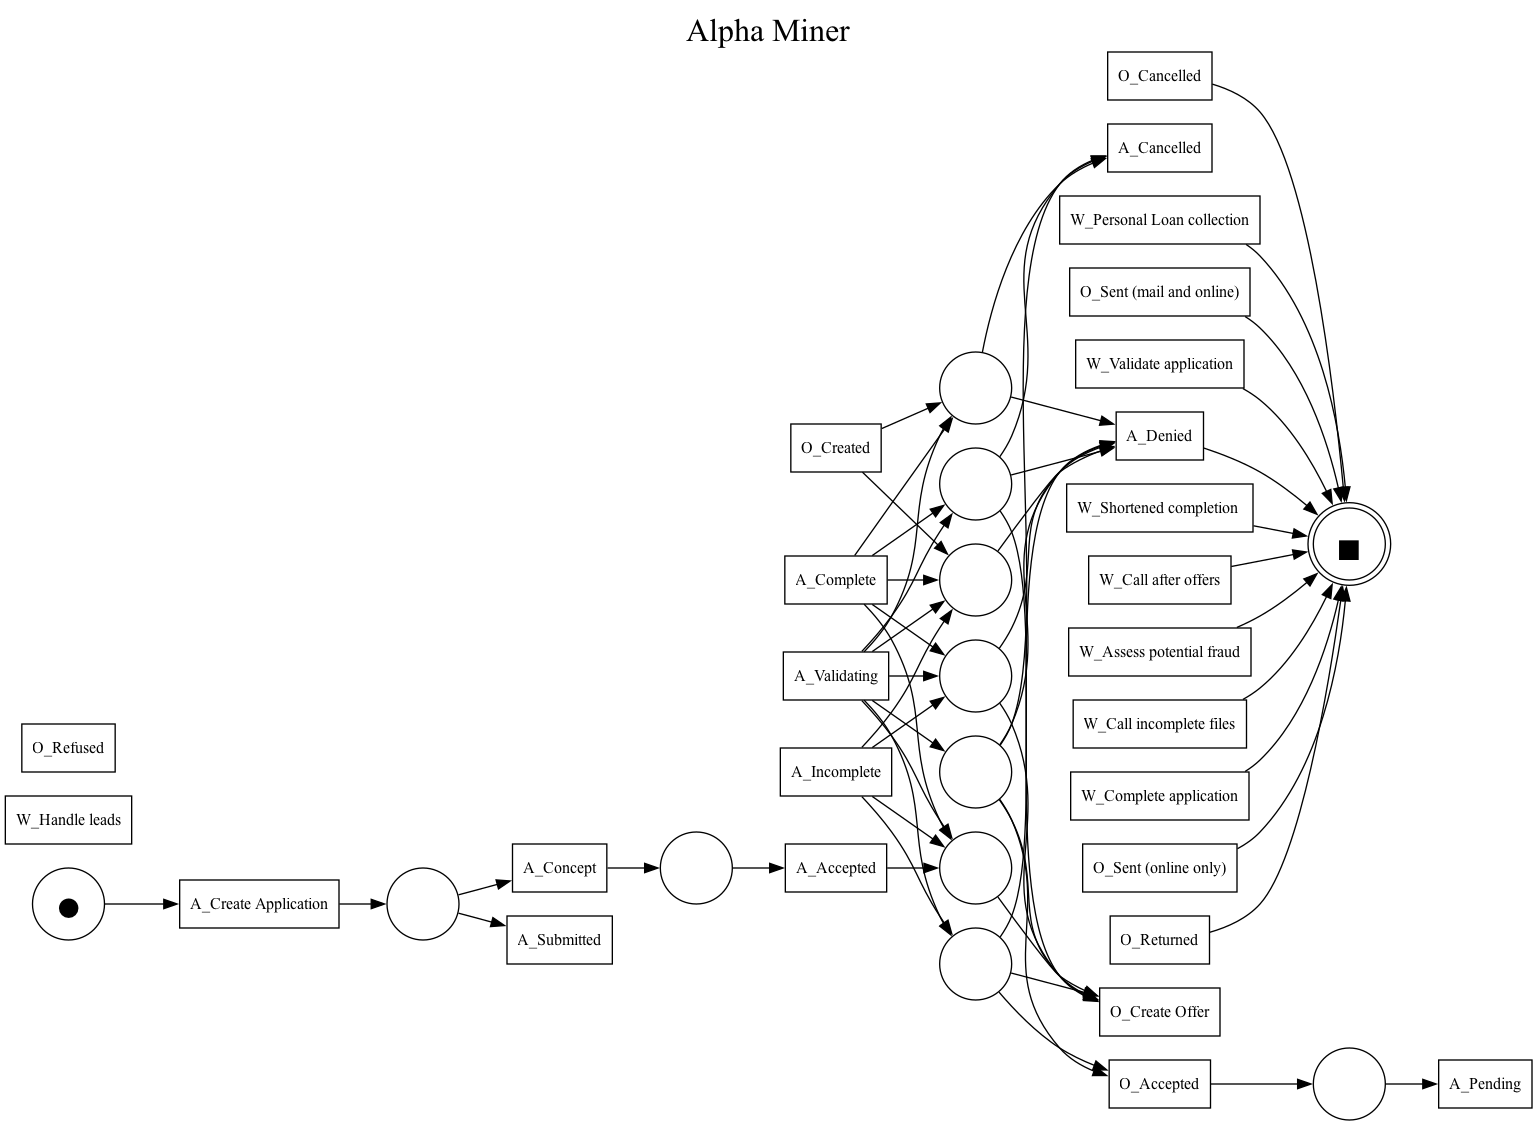

In [7]:
print("\n=== SECTION 3.4: PROCESS DISCOVERY ===")
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

print("\n=== SECTION 3.4.1: ALPHA MINER ===")
net, im, fm = alpha_miner.apply(log)
pm4py.view_petri_net(net,im,fm, graph_title = "Alpha Miner")


=== SECTION 3.4.2: HEURISTIC MINER ===


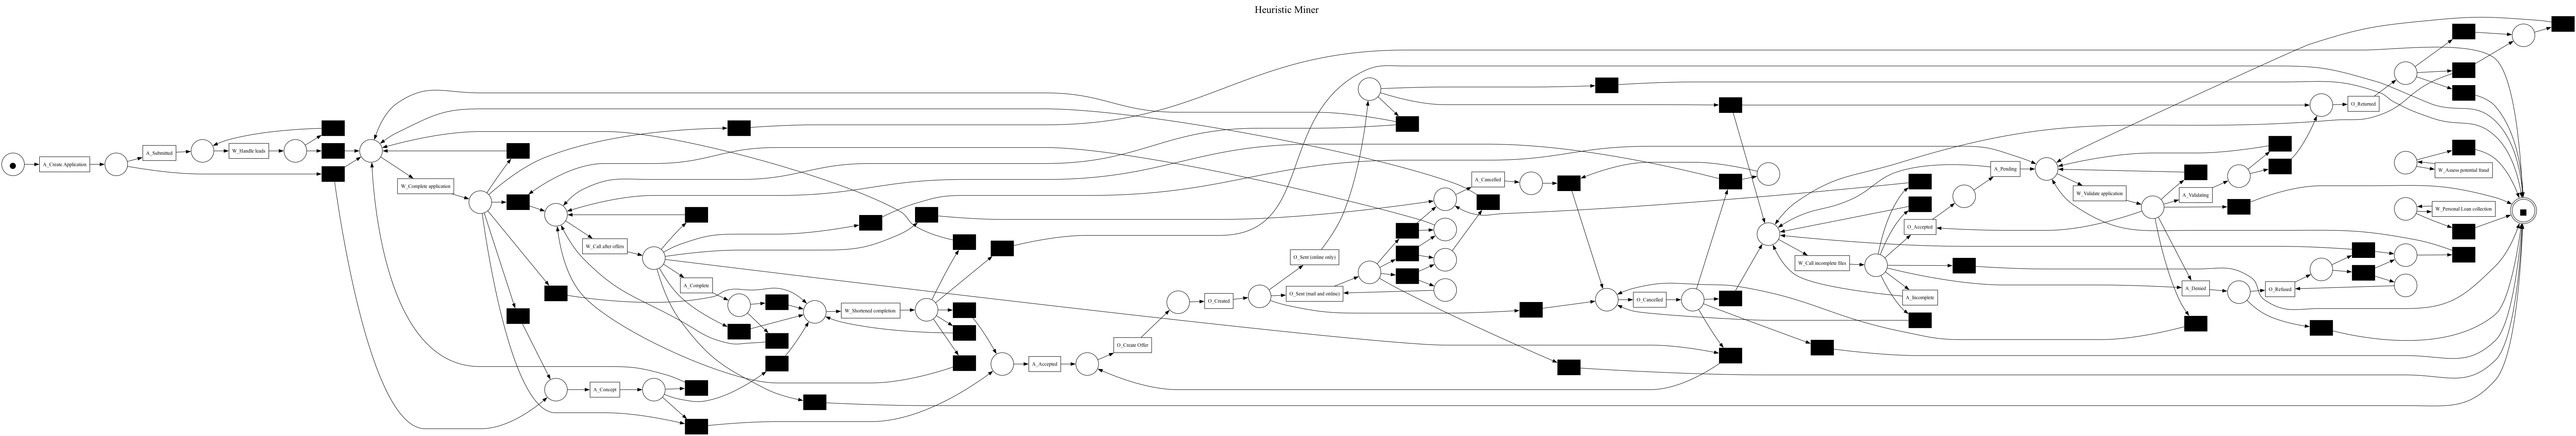

In [8]:
print("\n=== SECTION 3.4.2: HEURISTIC MINER ===")
parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.8}
net_h, im_h, fm_h = heuristics_miner.apply(log, parameters = parameters)
pm4py.view_petri_net(net_h,im_h,fm_h, graph_title = "Heuristic Miner ")



=== SECTION 3.4.3: INDUCTIVE MINER ===


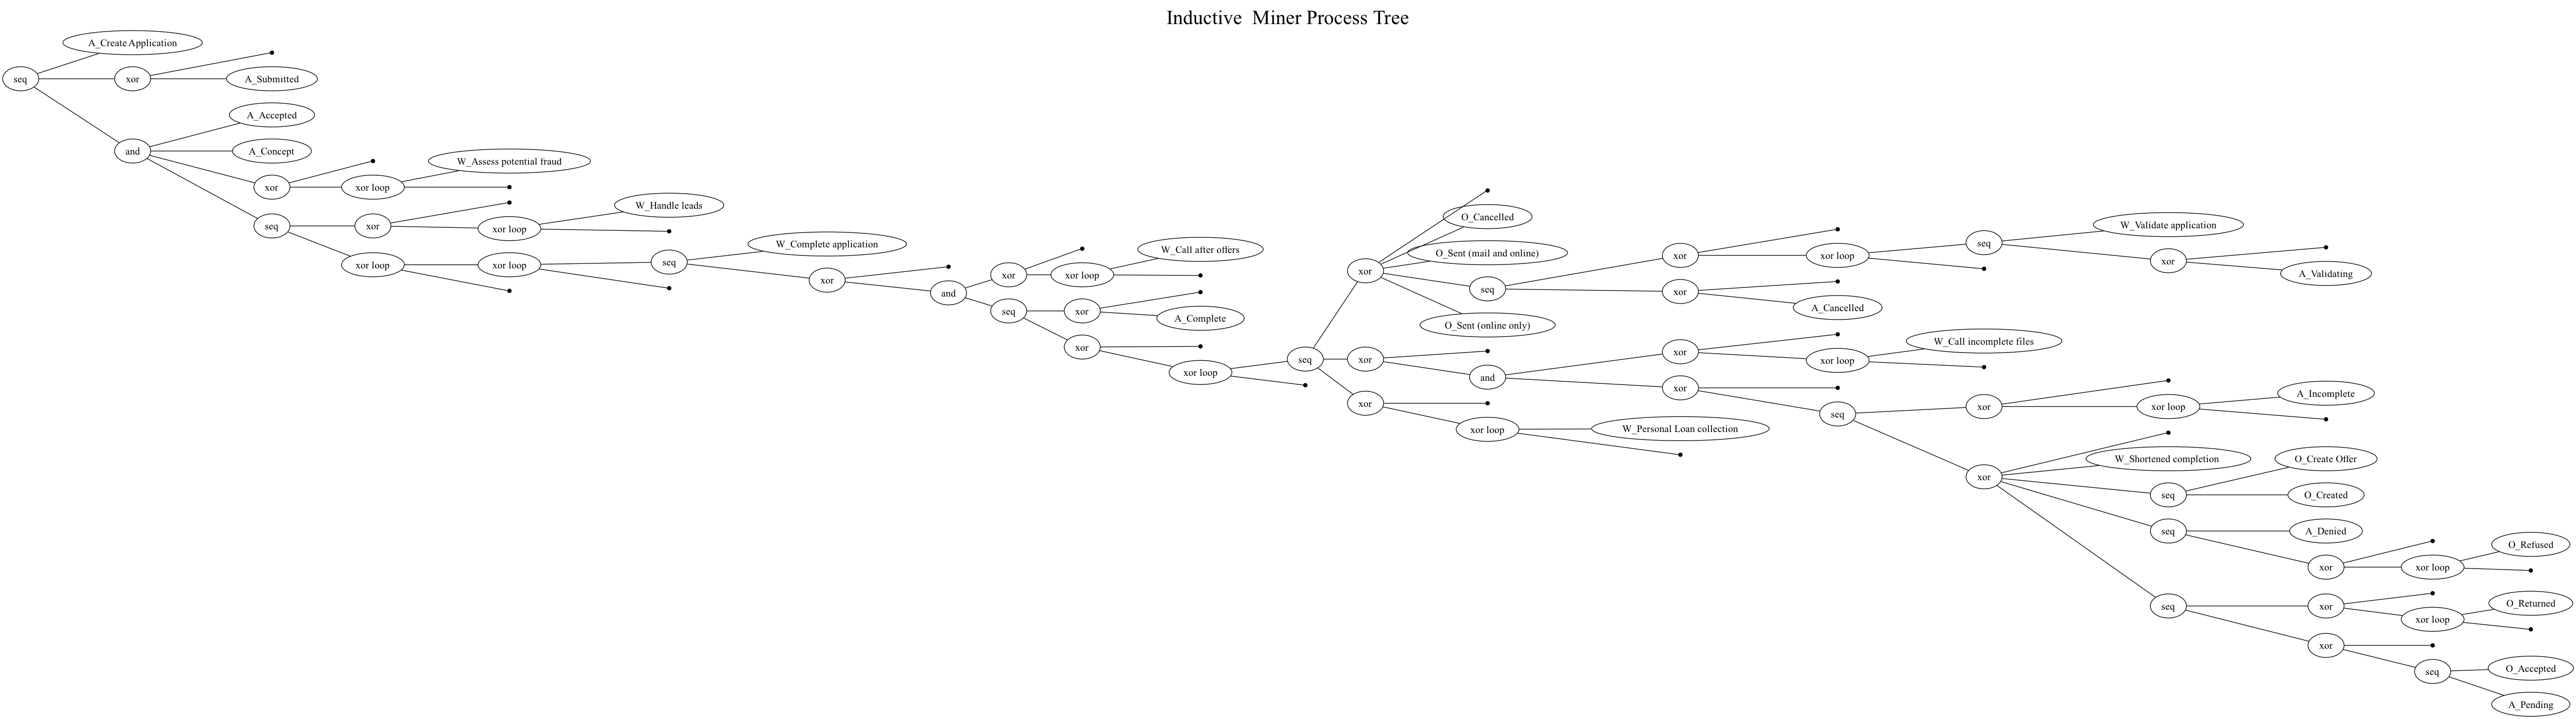

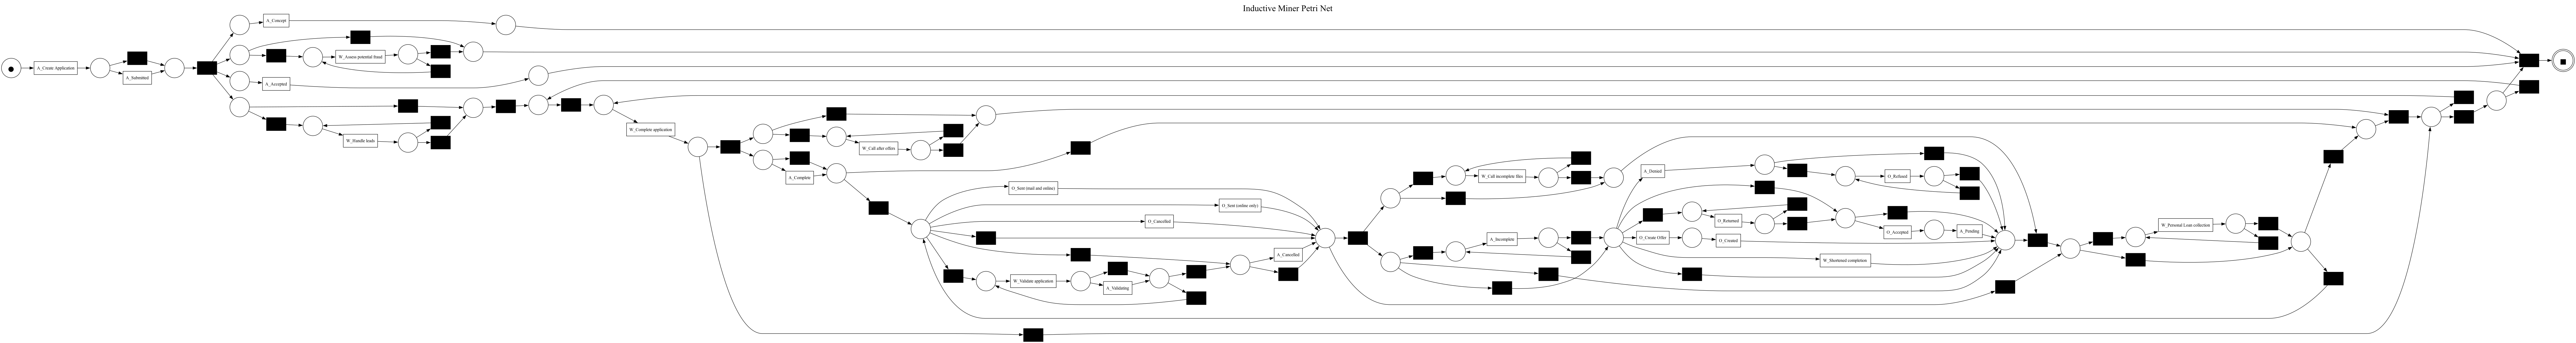

In [9]:
print("\n=== SECTION 3.4.3: INDUCTIVE MINER ===")
from pm4py.objects.conversion.process_tree import converter as pt_converter
processTree = inductive_miner.apply(log)
net_i, im_i, fm_i = pt_converter.apply(processTree)
pm4py.view_process_tree(processTree, graph_title = "Inductive  Miner Process Tree")
pm4py.view_petri_net(net_i, im_i, fm_i, graph_title = "Inductive Miner Petri Net")

In [10]:
print("\n=== SECTION 3.5: QUALITY METRICS ===")
from pm4py.algo.evaluation.replay_fitness.variants.token_replay import apply as token_replay

print("\n=== SECTION 3.5.1: TOKEN-BASED REPLAY FITNESS ===")
alpha_fit_tbr = token_replay(log,net,im,fm)
print(alpha_fit_tbr)
heur_fit_tbr = token_replay(log,net_h,im_h,fm_h)
print(heur_fit_tbr)
#In order to apply the same fitness method to inductive, w should convert first the process tree into a petri net
ind_fit_tbr = token_replay(log, net_i,im_i,fm_i)
print(ind_fit_tbr)

fitness_table = pd.DataFrame({
    'Algorithm' : ['Alpha-Miner', 'Heuristic-Miner', 'Inductive-Miner'],
    'Token Based Fitness' : [
        round(alpha_fit_tbr['log_fitness'], 3),
        round(heur_fit_tbr['log_fitness'], 3),
        round(ind_fit_tbr['log_fitness'], 3)
    ]
})
fitness_table


=== SECTION 3.5: QUALITY METRICS ===

=== SECTION 3.5.1: TOKEN-BASED REPLAY FITNESS ===


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:23<00:00, 665.24it/s]


{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.4038572365195623, 'log_fitness': 0.38258984617069436, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:56<00:00, 280.93it/s]


{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9484831370067827, 'log_fitness': 0.9550454122024806, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [01:09<00:00, 230.80it/s]

{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


,Algorithm,Token Based Fitness
0,Alpha-Miner,0.383
1,Heuristic-Miner,0.955
2,Inductive-Miner,1.000


In [11]:
print("\n=== SECTION 3.5.2: PRECISION ===")

from pm4py.algo.evaluation.precision.variants import etconformance_token as etconformance_token

prec_alpha = etconformance_token.apply(log,net,im,fm)
prec_heur = etconformance_token.apply(log,net_h,im_h,fm_h)
prec_ind = etconformance_token.apply(log,net_i,im_i,fm_i)

print("Precision (Alpha):", prec_alpha)
print("Precision (Heuristic):", prec_heur)
print("Precision (Inductive):", prec_ind)


=== SECTION 3.5.2: PRECISION ===


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [27:43<00:00, 158.66it/s]


Precision (Alpha): 0.09036668421905925
Precision (Heuristic): 0.671806675321126
Precision (Inductive): 0.1406587530076867


In [12]:
print("\n=== SECTION 3.5.3: GENERALIZATION ===")
from pm4py.algo.evaluation.generalization.variants import token_based as generalization_token_based

alpha_gen = generalization_token_based.apply(log,net,im,fm)
heur_gen = generalization_token_based.apply(log,net_h, im_h, fm_h)
ind_gen = generalization_token_based.apply(log, net_i, im_i, fm_i)

print("Generalization (Alpha):", alpha_gen)
print("Generalization (Heuristics):", heur_gen)
print("Generalization (Inductive):", ind_gen)


=== SECTION 3.5.3: GENERALIZATION ===


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [01:05<00:00, 243.84it/s]


Generalization (Alpha): 0.9824200959583872
Generalization (Heuristics): 0.9318999131893965
Generalization (Inductive): 0.9484917562396579


In [13]:
print("\n=== SECTION 3.5.4: SIMPLICITY ===")
#We focus on the general graph-theory metrics bcs the process specific ones are not applicable with petri nets
#what the Conformance Checking book suggests:
#size, density and connectivity
def simplicity_size(pn):
    #Number of nodes + arcs
    nodes = len(pn.places) + len(pn.transitions)
    arcs = len(pn.arcs)
    return nodes + arcs

def simplicity_density(pn):
    #Density = arcs / maximum possible arcs between all nodes Reflects how densely connected the model is.
    
    nodes = len(pn.places) + len(pn.transitions)
    max_arcs = nodes * (nodes-1) if nodes > 1 else 1
    return len(pn.arcs) / max_arcs

def simplicity_connectivity(pn):
    #Connectivity = arcs / nodes Measures average number of connections per node.
    nodes = len(pn.places) + len(pn.transitions)
    return len(pn.arcs) / nodes if nodes > 0 else 0

# Alpha Miner
simp_size_alpha = simplicity_size(net)
simp_dens_alpha = simplicity_density(net)
simp_conn_alpha = simplicity_connectivity(net)

# Heuristic Miner
simp_size_heur = simplicity_size(net_h)
simp_dens_heur = simplicity_density(net_h)
simp_conn_heur = simplicity_connectivity(net_h)

# Inductive Miner
simp_size_ind = simplicity_size(net_i)
simp_dens_ind = simplicity_density(net_i)
simp_conn_ind = simplicity_connectivity(net_i)

simp_df = pd.DataFrame({
    "Algorithm": ["Alpha-Miner", "Heuristic-Miner", "Inductive-Miner"],
    "Size (#nodes + arcs)": [simp_size_alpha, simp_size_heur, simp_size_ind],
    "Density (arcs/max_arcs)": [round(simp_dens_alpha, 4), round(simp_dens_heur, 4), round(simp_dens_ind, 4)],
    "Connectivity (arcs/nodes)": [round(simp_conn_alpha, 4), round(simp_conn_heur, 4), round(simp_conn_ind, 4)],
})
simp_df



=== SECTION 3.5.4: SIMPLICITY ===


,Algorithm,Size (#nodes + arcs),Density (arcs/max_arcs),Connectivity (arcs/nodes)
0,Alpha-Miner,93,0.0391,1.4474
1,Heuristic-Miner,308,0.0118,1.4640
2,Inductive-Miner,326,0.0092,1.2958


In [14]:
quality_summary = pd.DataFrame({
    "Algorithm": ["Alpha-Miner", "Heuristic-Miner", "Inductive-Miner"],
    "Fitness (Token-Based)": [
        round(alpha_fit_tbr["log_fitness"], 3),
        round(heur_fit_tbr["log_fitness"], 3),
        round(ind_fit_tbr["log_fitness"], 3)
    ],
    "Precision": [
        round(prec_alpha, 3),
        round(prec_heur, 3),
        round(prec_ind, 3)
    ],
    "Generalization": [
        round(alpha_gen, 3),
        round(heur_gen, 3),
        round(ind_gen, 3)
    ],
    "Size (#nodes + arcs)": [
        simp_size_alpha,
        simp_size_heur,
        simp_size_ind
    ],
    "Density": [
        round(simp_dens_alpha, 4),
        round(simp_dens_heur, 4),
        round(simp_dens_ind, 4)
    ],
    "Connectivity": [
        round(simp_conn_alpha, 4),
        round(simp_conn_heur, 4),
        round(simp_conn_ind, 4)
    ]
})
quality_summary.to_csv("Overall Quality Metrics of BPIC 2017")

In [27]:
print("\n===  QUALITY METRIC ANALYSIS OF MY BPMN 2.0 ===")
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

bpmn_path = "BPI Challenge 2017 Loan Application Process-6-2.bpmn"
bpmn_graph = pm4py.read_bpmn(bpmn_path)

net_bpmn, im_bpmn, fm_bpmn = bpmn_converter.apply(bpmn_graph)



===  QUALITY METRIC ANALYSIS OF MY BPMN 2.0 ===


In [28]:
print("\n=== SECTION 6: PROCESS DISCOVERY BPMN 2.0 ===")
from pm4py.algo.evaluation.replay_fitness.variants.token_replay import apply as token_replay

print("\n=== TOKEN-BASED FITNESS BPMN MODEL ===")
bpmn_fit_tbr = token_replay(log, net_bpmn, im_bpmn, fm_bpmn)

print("Raw result:", bpmn_fit_tbr)
print("Log fitness:", round(bpmn_fit_tbr["log_fitness"], 3))
print("Perc. of fitting traces:", round(bpmn_fit_tbr["perc_fit_traces"], 3))
import pm4py

# 1) Log aktiviteleri
log_acts = set(pm4py.get_event_attribute_values(log, "concept:name").keys())
print("Number of distinct log activities:", len(log_acts))

# 2) Modeldeki transition label'ları
model_acts = set(
    t.label for t in net_bpmn.transitions
    if hasattr(t, "label") and t.label is not None
)
print("Number of labeled transitions in BPMN-derived net:", len(model_acts))

# 3) Kesişim ve farklar
common = log_acts & model_acts
only_in_log = log_acts - model_acts
only_in_model = model_acts - log_acts

print("\nCommon labels (example):", sorted(list(common))[:15])
print("\nIn log but NOT in model (example):", sorted(list(only_in_log))[:15])
print("\nIn model but NOT in log (example):", sorted(list(only_in_model))[:15])


=== SECTION 6: PROCESS DISCOVERY BPMN 2.0 ===

=== TOKEN-BASED FITNESS BPMN MODEL ===


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [01:08<00:00, 234.26it/s]


Raw result: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8998744372291521, 'log_fitness': 0.9102959271062401, 'percentage_of_fitting_traces': 0.0}
Log fitness: 0.91
Perc. of fitting traces: 0.0
Number of distinct log activities: 26
Number of labeled transitions in BPMN-derived net: 26

Common labels (example): ['A_Accepted', 'A_Cancelled', 'A_Complete', 'A_Concept', 'A_Create Application', 'A_Denied', 'A_Incomplete', 'A_Pending', 'A_Submitted', 'A_Validating', 'O_Accepted', 'O_Cancelled', 'O_Create Offer', 'O_Created', 'O_Refused']

In log but NOT in model (example): []

In model but NOT in log (example): []


In [ ]:
pm4py.conformance.conformance_diagnostics_alignments

In [17]:
from pm4py.statistics.end_activities.log import get as end_acts_get

end_acts = end_acts_get.get_end_activities(log)
print("End activities in log (with counts):")
for act, cnt in end_acts.items():
    print(act, "→", cnt)


End activities in log (with counts):
W_Validate application → 12662
O_Cancelled → 4436
W_Call after offers → 9457
W_Call incomplete files → 4676
W_Complete application → 144
W_Assess potential fraud → 102
W_Personal Loan collection → 2
W_Shortened completion  → 5
A_Denied → 1
O_Sent (online only) → 8
O_Sent (mail and online) → 15
O_Returned → 1


In [18]:
from pm4py.algo.evaluation.replay_fitness.variants import token_replay as fitness_eval

print("\n=== VARIANT-LEVEL FITNESS ANALYSIS (BPMN MODEL) ===")

CASE = "case:concept:name"
ACT  = "concept:name"

case_variants = (
    log_df
    .groupby(CASE)[ACT]
    .apply(list)   
)


variant_map = {}
for case_id, act_list in case_variants.items():
    var = tuple(act_list)   
    if var not in variant_map:
        variant_map[var] = []
    variant_map[var].append(case_id)

variant_stats = []


for var, case_ids in variant_map.items():
    sub_df = log_df[log_df[CASE].isin(case_ids)]

    if sub_df.empty:
        continue

    
    res = fitness_eval.apply(sub_df, net_bpmn, im_bpmn, fm_bpmn)
    f = res["log_fitness"]

    variant_stats.append((var, f, len(case_ids)))


variant_stats.sort(key=lambda x: x[1])  # x[1] = fitness

print("\n=== WORST 10 VARIANTS BY LOG FITNESS ===")
for var, f, n in variant_stats[:10]:
    print(f"Fitness: {round(f, 3)} | Cases: {n}")
    print("Variant:", " → ".join(var))
    print("---")



=== VARIANT-LEVEL FITNESS ANALYSIS (BPMN MODEL) ===

=== WORST 10 VARIANTS BY LOG FITNESS ===
Fitness: 0.341 | Cases: 1
Variant: A_Create Application → W_Complete application → W_Complete application → A_Concept → A_Accepted → O_Create Offer → O_Created → O_Create Offer → O_Created → O_Sent (mail and online) → O_Sent (mail and online) → W_Complete application → W_Call after offers → W_Call after offers → A_Complete → W_Call after offers → O_Create Offer → O_Created → O_Sent (mail and online) → W_Call after offers → W_Call after offers → W_Call after offers → W_Validate application → W_Validate application → A_Validating → O_Returned → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Validate application → W_Call incomplete files → W_Cal

In [29]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

print("\n=== PRECISION BPMN MODEL ===")
bpmn_precision = precision_evaluator.apply(log, net_bpmn, im_bpmn, fm_bpmn)
print("Precision:", round(bpmn_precision, 3))

print("\n=== GENERALIZATION BPMN MODEL ===")
bpmn_generalization = generalization_evaluator.apply(log, net_bpmn, im_bpmn, fm_bpmn)
print("Generalization:", round(bpmn_generalization, 3))



=== PRECISION BPMN MODEL ===


computing precision with alignments, completed variants :: 100%|██████████| 263907/263907 [13:28<00:00, 326.58it/s]


Precision: 0.755

=== GENERALIZATION BPMN MODEL ===


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:40<00:00, 395.13it/s]


Generalization: 0.901


In [30]:
def simplicity_size(pn):
    #Number of nodes + arcs
    nodes = len(pn.places) + len(pn.transitions)
    arcs = len(pn.arcs)
    return nodes + arcs

def simplicity_density(pn):
    #Density = arcs / maximum possible arcs between all nodes Reflects how densely connected the model is.
    
    nodes = len(pn.places) + len(pn.transitions)
    max_arcs = nodes * (nodes-1) if nodes > 1 else 1
    return len(pn.arcs) / max_arcs

def simplicity_connectivity(pn):
    #Connectivity = arcs / nodes Measures average number of connections per node.
    nodes = len(pn.places) + len(pn.transitions)
    return len(pn.arcs) / nodes if nodes > 0 else 0

print("\n=== SIMPLICITY BPMN MODEL ===")
simp_size_bpmn = simplicity_size(net_bpmn)
simp_dens_bpmn = simplicity_density(net_bpmn)
simp_conn_bpmn = simplicity_connectivity(net_bpmn)
print("Connectivity: ",simp_conn_bpmn)
print("Density: ",simp_dens_bpmn)
print("Size: ",simp_size_bpmn)



=== SIMPLICITY BPMN MODEL ===
Connectivity:  1.2380952380952381
Density:  0.01491681009753299
Size:  188



=== CREDIT SCORE ANALYSIS ===
count    15260.000000
mean       897.783814
std        100.109325
min        541.000000
25%        833.000000
50%        904.000000
75%        970.000000
max       1145.000000
Name: CreditScore, dtype: float64


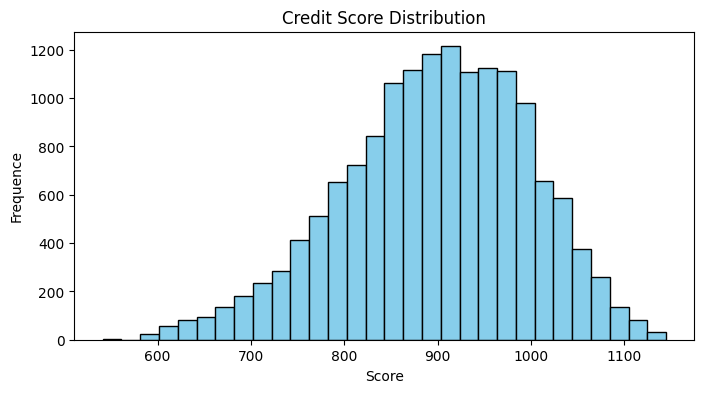

In [ ]:
print("\n=== CREDIT SCORE ANALYSIS ===")
import matplotlib.pyplot as plt
# CreditScore Grouping
# First with describe() to see how the values are changing 

# 1. only valid scores
valid_scores = log_df.loc[(log_df["CreditScore"] > 0) & (log_df["CreditScore"].notna()), "CreditScore"]

if len(valid_scores) > 0:
    #desribe
    print(valid_scores.describe())

    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(valid_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title("Credit Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequence")
    plt.show()
else:
    print("Nothing to analyse")


=== REQUESTED AMOUNT ANALYSIS ===
count    1.089456e+06
mean     1.849487e+04
std      1.551521e+04
min      6.000000e+02
25%      8.000000e+03
50%      1.500000e+04
75%      2.500000e+04
max      4.500000e+05
Name: case:RequestedAmount, dtype: float64


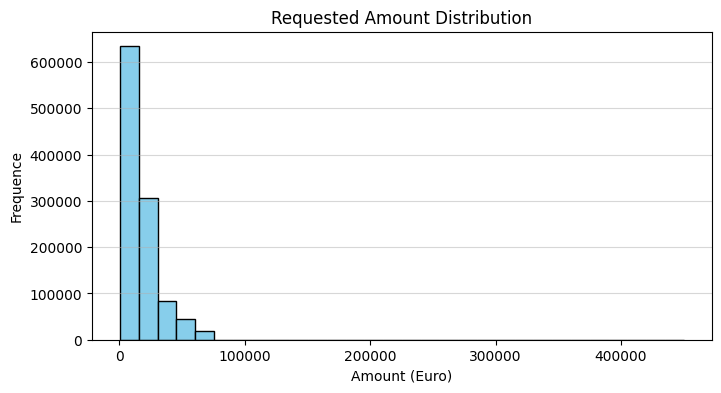

In [22]:
print("\n=== REQUESTED AMOUNT ANALYSIS ===")

col_name = "case:RequestedAmount"

valid_scores = log_df.loc[
        (log_df[col_name] > 0) & (log_df[col_name].notna()), 
        col_name
    ]

if len(valid_scores) > 0:
    #Describe
    print(valid_scores.describe())

    #Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(valid_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title("Requested Amount Distribution")
    plt.xlabel("Amount (Euro)")
    plt.ylabel("Frequence")
    plt.grid(axis='y', alpha=0.5)
    plt.show()
else:
    print("Nothing to analyse")
    
    


In [23]:

import pandas as pd
# The histogram showed a normal distribution
# Splitting into 3 equal buckets (Low, Medium, High) 

# For missing/zero
log_df["case:CreditScoreCat"] = "Missing/Zero"

# Identify valid scores: Positive numbers that are not NaN
valid_cs_mask = (log_df["CreditScore"] > 0) & (log_df["CreditScore"].notna())
valid_cs_data = log_df.loc[valid_cs_mask, "CreditScore"]

if len(valid_cs_data) > 0:
    # qcut divides the data into 'q' equal-sized buckets
    # q=3 --> I get the bottom 33%, middle 33%, and top 33%
    log_df.loc[valid_cs_mask, "case:CreditScoreCat"] = pd.qcut(
        valid_cs_data, 
        q=3, 
        labels=["Low Score", "Medium Score", "High Score"]
    )
    print("Credit Score segmentation complete.")
    print(log_df["case:CreditScoreCat"].value_counts().sort_index())
else:
    print("No valid credit scores found to segment.")
    
# The histogram was Right-Skewed 
# Using Quartiles q=4 ensures each group has roughly the same number of cases ca. 25% each.

amt_col = "case:RequestedAmount"
log_df["case:RequestedAmountCat"] = pd.NA

if amt_col in log_df.columns:
    # Filter valid amounts
    valid_amt_mask = (log_df[amt_col] > 0) & (log_df[amt_col].notna())
    valid_amt_data = log_df.loc[valid_amt_mask, amt_col]

    if len(valid_amt_data) > 0:
        # Split into 4 equal parts based on the histogram and statistics
        log_df.loc[valid_amt_mask, "case:RequestedAmountCat"] = pd.qcut(
            valid_amt_data, 
            q=4, 
            labels=["Micro (<25%)", "Small (25-50%)", "Medium (50-75%)", "Large (>75%)"]
        )
        print("\nRequested Amount segmentation complete.")
        print(log_df["case:RequestedAmountCat"].value_counts().sort_index())
    else:
        print("No valid amounts found to segment.")
else:
    print(f"Column '{amt_col}' not found in dataframe.")

Credit Score segmentation complete.
case:CreditScoreCat
High Score         5075
Low Score          5151
Medium Score       5034
Missing/Zero    1187007
Name: count, dtype: int64

Requested Amount segmentation complete.
case:RequestedAmountCat
Large (>75%)       219085
Medium (50-75%)    239724
Micro (<25%)       280878
Small (25-50%)     349769
Name: count, dtype: int64



ATTRIBUTE-DRIVEN SEGMENTATION


ANALYZING ATTRIBUTE: case:ApplicationType


 Segment: Limit raise (Attribute: case:ApplicationType)
  Cases: 3389
  Avg Duration: 17.19 days
  Top Bottleneck (Avg): W_Call after offers -> 47.30 hours

 Segment: New credit (Attribute: case:ApplicationType)
  Cases: 28120
  Avg Duration: 22.47 days
  Top Bottleneck (Avg): W_Personal Loan collection -> 432.66 hours


ANALYZING ATTRIBUTE: case:LoanGoal


 Segment: Boat (Attribute: case:LoanGoal)
  Cases: 201
  Avg Duration: 21.25 days
  Top Bottleneck (Avg): W_Call after offers -> 60.28 hours

 Segment: Business goal (Attribute: case:LoanGoal)
  Cases: 30
  Avg Duration: 22.70 days
  Top Bottleneck (Avg): O_Sent (online only) -> 88.22 hours

 Segment: Car (Attribute: case:LoanGoal)
  Cases: 9328
  Avg Duration: 20.71 days
  Top Bottleneck (Avg): W_Call after offers -> 59.18 hours

 Segment: Caravan / Camper (Attribute: case:LoanGoal)
  Cases: 369
  Avg Duration: 19.18 days
  Top Bottleneck (Avg): W_Call aft

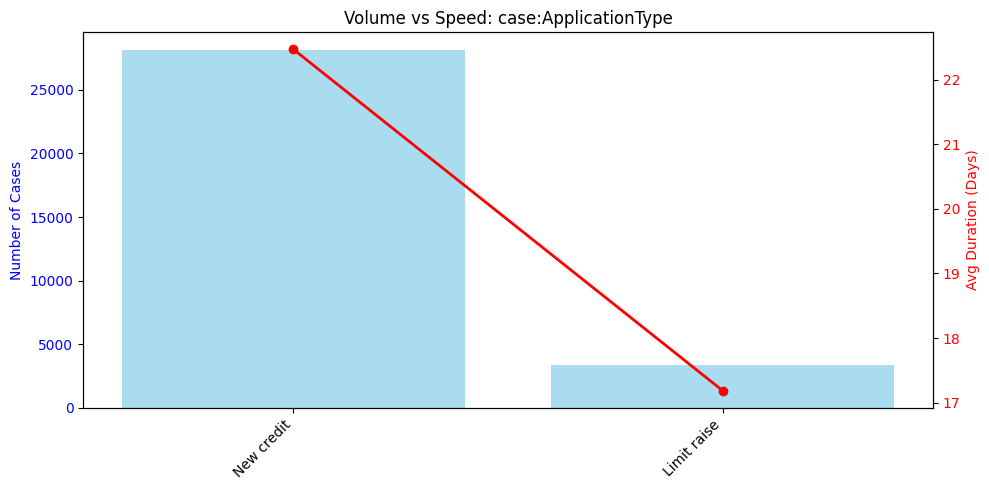

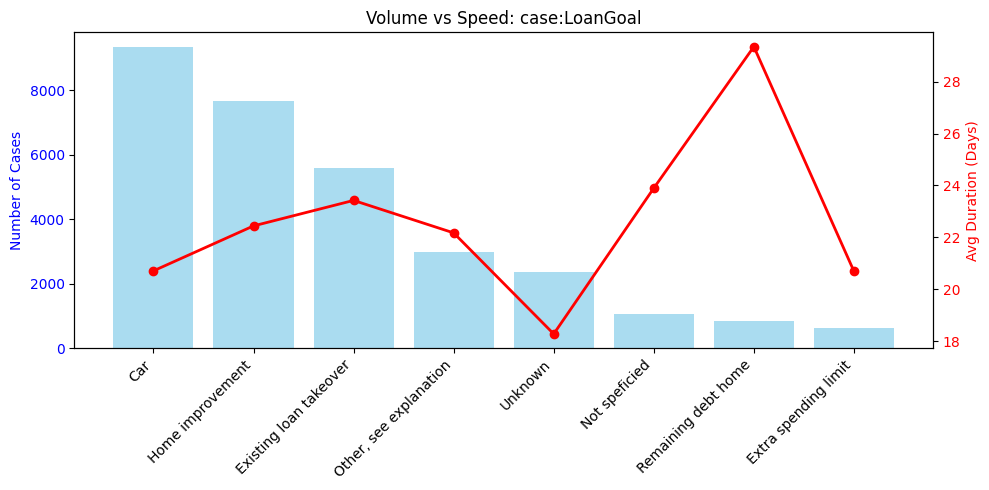

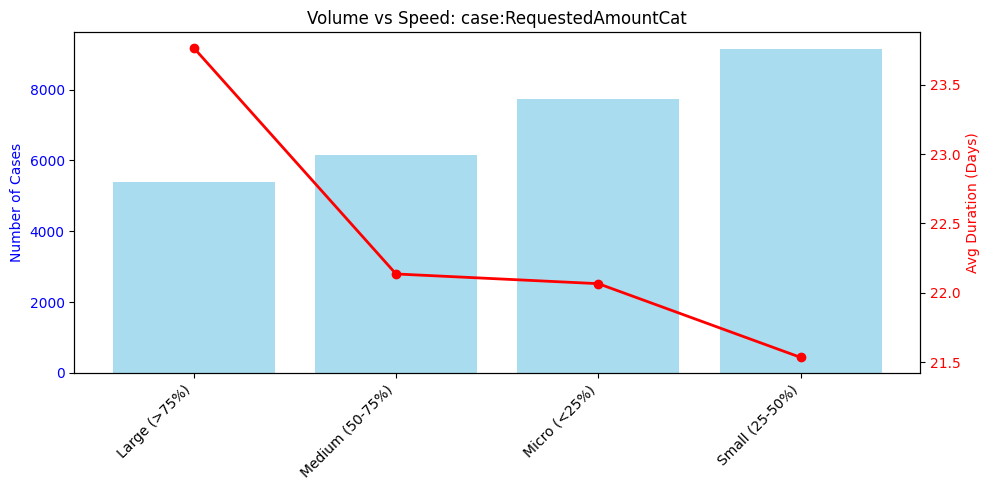

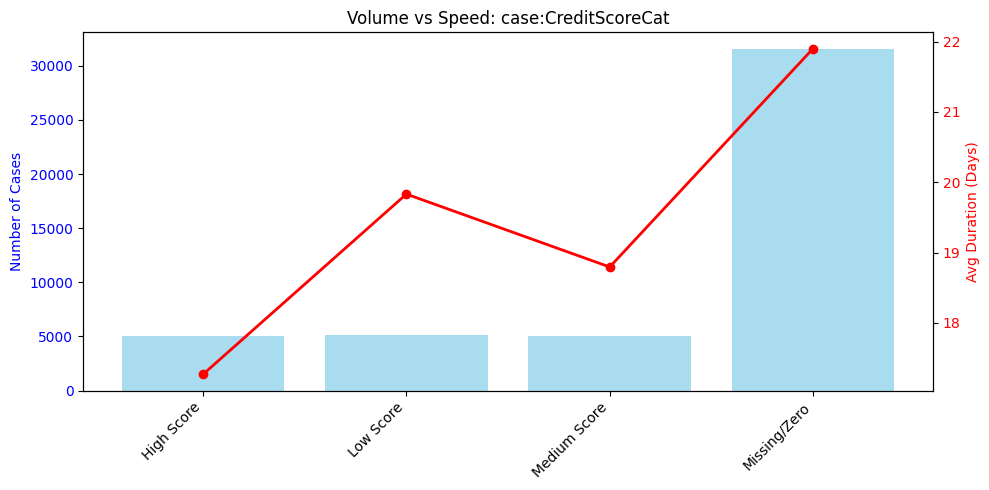

In [24]:
import matplotlib.pyplot as plt

print("\nATTRIBUTE-DRIVEN SEGMENTATION")

CASE = "case:concept:name"
TS = "time:timestamp"  

# Attributes chosen for segmentation
ATTRIBUTES = [
    "case:ApplicationType",
    "case:LoanGoal",
    "case:RequestedAmountCat", # in previous step
    "case:CreditScoreCat"      # in previous step
]

all_cluster_summaries = []
all_bottlenecks = []

def performance_report_df(sub_df: pd.DataFrame, attr_name: str, attr_value):
    #duration and bottlenecks for a specific seg
    
    # case-level metrics
    perf = (
        sub_df.groupby(CASE)[TS]
              .agg(["min", "max", "count"])
              .rename(columns={"min": "start", "max": "end", "count": "num_events"})
    )
    
    perf["duration_days"] = (perf["end"] - perf["start"]).dt.total_seconds() / 86400

    # Activity-level Transition Time (Bottlenecks)
    sub_df = sub_df.sort_values([CASE, TS])
    
    sub_df["next_time"] = sub_df.groupby(CASE)[TS].shift(-1)
    sub_df["transition_sec"] = (sub_df["next_time"] - sub_df[TS]).dt.total_seconds()

    bottlenecks = (
        sub_df.dropna(subset=["transition_sec"])
              .groupby("concept:name")["transition_sec"]
              .agg(["mean", "median", "count"])
              .sort_values(by="mean", ascending=False)
    )

    print(f"\n Segment: {attr_value} (Attribute: {attr_name})")
    print(f"  Cases: {len(perf)}")
    print(f"  Avg Duration: {perf['duration_days'].mean():.2f} days")

    bottleneck_rows = []

    if not bottlenecks.empty:
        # only the longest activity
        act = bottlenecks.index[0]
        row = bottlenecks.iloc[0]

        print(f"  Top Bottleneck (Avg): {act} -> {row['mean']/3600:.2f} hours")

        bottleneck_rows.append({
            "attribute": attr_name,
            "value": str(attr_value),
            "activity_from": act,
            "avg_transition_hours": round(row["mean"] / 3600, 2), 
            "median_transition_hours": round(row["median"] / 3600, 2),
            "event_count": row["count"]
        })
    else:
        print("  No bottlenecks (no transitions) found for this segment.")

    summary_row = {
        "attribute": attr_name,
        "value": str(attr_value),
        "num_cases": len(perf),
        "avg_duration_days": perf["duration_days"].mean(),
        "median_duration_days": perf["duration_days"].median(),
        "avg_num_events": perf["num_events"].mean()
    }

    return summary_row, bottleneck_rows

for attr_name in ATTRIBUTES:
    if attr_name not in log_df.columns:
        print(f"\nSkipping {attr_name}: Column not found.")
        continue

    print(f"\n\nANALYZING ATTRIBUTE: {attr_name}\n")

    # Extract unique values while preserving categorical order
    if isinstance(log_df[attr_name].dtype, pd.CategoricalDtype):
        unique_vals = log_df[attr_name].cat.categories
        # Filternonly exisiting data
        existing_vals = log_df[attr_name].unique()
        unique_vals = [v for v in unique_vals if v in existing_vals]
    else:
        unique_vals = sorted(log_df[attr_name].dropna().unique())

    # Iterate through segments
    for val in unique_vals:
        case_ids = log_df.loc[log_df[attr_name] == val, CASE].unique()
        
        if len(case_ids) == 0: continue

        sub_df = log_df[log_df[CASE].isin(case_ids)].copy()
        
        s_row, b_rows = performance_report_df(sub_df, attr_name, val)
        all_cluster_summaries.append(s_row)
        all_bottlenecks.extend(b_rows)

summary_df = pd.DataFrame(all_cluster_summaries)
bottleneck_df = pd.DataFrame(all_bottlenecks)

summary_df.round(2).to_csv("tables/segment_performance_summary.csv", index=False)
bottleneck_df.round(2).to_csv("tables/segment_bottlenecks.csv", index=False)

print("\n VISUALIZATION ")
for attr in summary_df["attribute"].unique():
    sub = summary_df[summary_df["attribute"] == attr].copy()

    if "Cat" not in attr: 
        sub = sub.sort_values("num_cases", ascending=False).head(8)

    fig, ax1 = plt.subplots(figsize=(10, 5))
    #Case Volume
    bars = ax1.bar(sub["value"], sub["num_cases"], color='skyblue', alpha=0.7, label='Case Volume')
    ax1.set_ylabel("Number of Cases", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.xticks(rotation=45, ha="right")

    #Average Duration
    ax2 = ax1.twinx()
    ax2.plot(sub["value"], sub["avg_duration_days"], color='red', marker='o', linewidth=2, label='Avg Duration')
    ax2.set_ylabel("Avg Duration (Days)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title(f"Volume vs Speed: {attr}")
    plt.tight_layout()
    plt.show()



 THE STEP TO FIND OUT WHY AND WHEN THE PROCESS IS SLOW

 TIME-SERIES ANALYSIS 


/var/folders/fc/cxfmlskd2b576brphjk3mb7m0000gn/T/ipykernel_4850/3589370121.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_starts["case_start_month"] = case_starts[TS].dt.to_period("M")



Calculating Monthly Trends (Volume vs Duration)


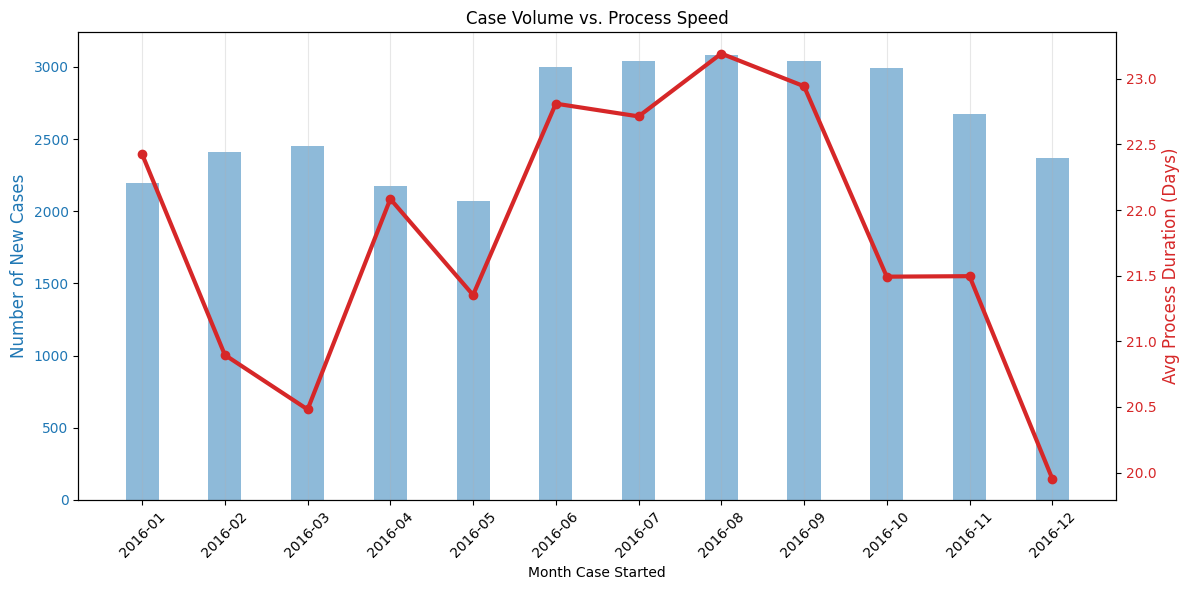


Deep Analysis: Stability of 'W_Personal Loan collection'


/var/folders/fc/cxfmlskd2b576brphjk3mb7m0000gn/T/ipykernel_4850/3589370121.py:82: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bottleneck_df["event_month"] = bottleneck_df[TS].dt.to_period("M")


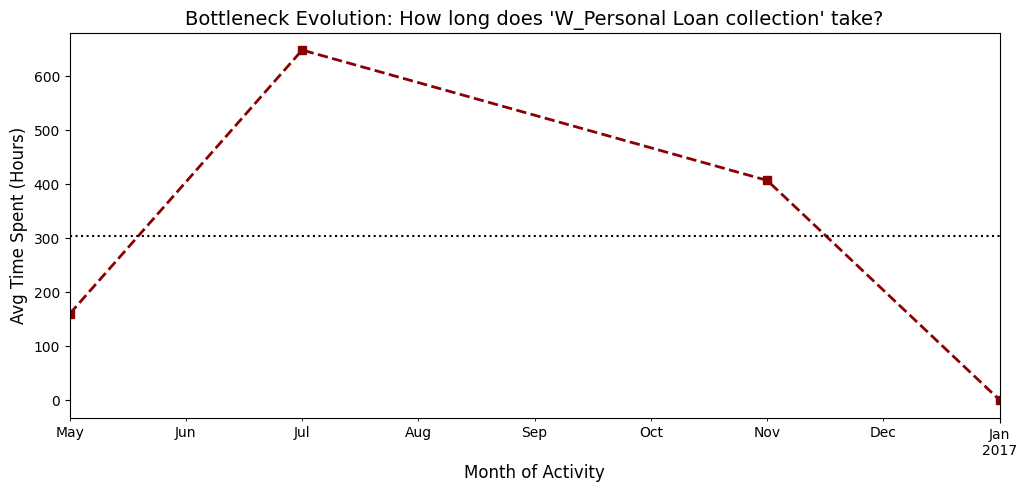

In [25]:
print("\n THE STEP TO FIND OUT WHY AND WHEN THE PROCESS IS SLOW")
print("\n TIME-SERIES ANALYSIS ")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# define exact column names based on your list
CASE = 'case:concept:name'
TS = 'time:timestamp'
ACTIVITY = 'concept:name'

# Start Month for every case
# group by case id to find the first timestamp of the case
case_starts = log_df.groupby(CASE)[TS].min().reset_index()
# Converting to Month with pandas
case_starts["case_start_month"] = case_starts[TS].dt.to_period("M")

# add a new column with left join
if "case_start_month" not in log_df.columns:
    log_df = log_df.merge(case_starts[[CASE, "case_start_month"]], on=CASE, how="left")


# Volume vs Speed Analysis
print("\nCalculating Monthly Trends (Volume vs Duration)")
case_durations = log_df.groupby(CASE).agg(
    start_month=("case_start_month", "first"),
    start_time=(TS, "min"),
    end_time=(TS, "max")
)
case_durations["duration_days"] = (case_durations["end_time"] - case_durations["start_time"]).dt.total_seconds() / 86400

# aggregate by Month
monthly_trends = case_durations.groupby("start_month").agg(
    case_volume=("start_time", "count"),
    avg_duration_days=("duration_days", "mean")
).sort_index()

monthly_trends.index = monthly_trends.index.astype(str)

# scalability chart
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("Case Volume vs. Process Speed")
ax1.set_xlabel("Month Case Started")

# bar Chart Volume (Matplotlib native function)
color_vol = 'tab:blue'
ax1.set_ylabel('Number of New Cases', color=color_vol, fontsize=12)

ax1.bar(monthly_trends.index, monthly_trends["case_volume"], color=color_vol, alpha=0.5, width=0.4, label='Volume')
ax1.tick_params(axis='y', labelcolor=color_vol)

# line Chart  Duration (Matplotlib native function)
ax2 = ax1.twinx()
color_dur = 'tab:red'
ax2.set_ylabel('Avg Process Duration (Days)', color=color_dur, fontsize=12)

ax2.plot(monthly_trends.index, monthly_trends["avg_duration_days"], color=color_dur, marker='o', linewidth=3, label='Duration')
ax2.tick_params(axis='y', labelcolor=color_dur)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add grid and show
ax1.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# the worst bottleneck --> W_Personal Loan collection
target_activity = "W_Personal Loan collection"
print(f"\nDeep Analysis: Stability of '{target_activity}'")


sub_df = log_df.sort_values([CASE, TS]).copy() #chronological first cases than timestamp
sub_df["next_time"] = sub_df.groupby(CASE)[TS].shift(-1)
sub_df["wait_sec"] = (sub_df["next_time"] - sub_df[TS]).dt.total_seconds()

# Filter only for W_Personal loan collection
bottleneck_df = sub_df[sub_df[ACTIVITY] == target_activity].copy()

if len(bottleneck_df) > 0:
    # group by the month event happened --> the workload on the staff in that specific month
    bottleneck_df["event_month"] = bottleneck_df[TS].dt.to_period("M")
    
    # Calculate average wait in Hours
    bn_trend = bottleneck_df.groupby("event_month")["wait_sec"].mean() / 3600 


    plt.figure(figsize=(12, 5))
    
    bn_trend.plot(kind='line', color='darkred', marker='s', linewidth=2, linestyle='--')
    
    plt.title(f"Bottleneck Evolution: How long does '{target_activity}' take?", fontsize=14)
    plt.ylabel("Avg Time Spent (Hours)", fontsize=12)
    plt.xlabel("Month of Activity", fontsize=12)
    #avg benchmark 
    plt.axhline(y=bn_trend.mean(), color='black', linestyle=':', label=f'Yearly Avg ({bn_trend.mean():.0f}h)')
    plt